<a href="https://colab.research.google.com/github/dantekliwadenko/proyectomodulo/blob/main/segmentacionmiocardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AsCiDEN Proyecto no astronómico  
Segmentación del Miocardio

Grupo 13:  
Dante Kliwadenko  
Francesco Castellani  
Gustavo Cardoza

Casi todo copiado de https://colab.research.google.com/drive/1oGDqlVuBFqzcYu12_L53bjkutBkz9_ne

In [1]:
# Imports

import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from google.colab import drive

In [13]:
# Carga los archivos del drive

drive.mount('/content/drive')
train_imgs = np.load('/content/drive/MyDrive/proyecto modulo/train_imgs.npy')
train_annot = np.load('/content/drive/MyDrive/proyecto modulo/train_annot.npy')
val_imgs = np.load('/content/drive/MyDrive/proyecto modulo/val_imgs.npy')
val_annot = np.load('/content/drive/MyDrive/proyecto modulo/val_annot.npy')
test_imgs = np.load('/content/drive/MyDrive/proyecto modulo/test_imgs.npy')
test_annot = np.load('/content/drive/MyDrive/proyecto modulo/test_annot.npy')

# Esto es para que se mezclen las imagenes en los grupos

train_ids = np.arange(len(train_imgs))
test_ids = np.arange(len(test_imgs))
val_ids = np.arange(len(val_imgs))
random.Random(1).shuffle(train_ids)
random.Random(2).shuffle(test_ids)
random.Random(3).shuffle(val_ids)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Constantes

seed = 0
random.seed = seed
np.random.seed = seed
tf.seed = seed
image_size = 256
batch_size = 16
epochs = 30

In [21]:
# Código de U-Net

class DataGen(keras.utils.Sequence):
  def __init__(self, ids, imgs, annot):
    self.ids = ids
    self.imgs = imgs
    self.annot = annot
    self.batch_size = batch_size
    self.image_size = image_size
    self.on_epoch_end()

  def __load__(self, k):
    z = np.zeros((image_size, image_size))
    imgs_k = self.imgs[k] / 255.0
    annot_k = self.annot[k] / 2.0
    imgs = np.transpose(np.array([imgs_k, z, z]))
    annot = np.transpose(np.array([annot_k]))
    return imgs, annot

  def __getitem__(self, i):
    if (i + 1) * self.batch_size > len(self.ids):
      self.batch_size = len(self.ids) - i * self.batch_size
    imgs = []
    annot = []
    for k in self.ids[i * self.batch_size : (i + 1) * self.batch_size]:
      _imgs, _annot = self.__load__(k)
      imgs.append(_imgs)
      annot.append(_annot)
    imgs = np.array(imgs)
    annot = np.array(annot)
    return imgs, annot

  def on_epoch_end(self):
    pass

  def __len__(self):
    return int(np.ceil(len(self.ids)/float(self.batch_size)))

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
  return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
  us = keras.layers.UpSampling2D((2, 2))(x)
  concat = keras.layers.Concatenate()([us, skip])
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  return c

def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = keras.layers.Input((image_size, image_size, 3))
  p0 = inputs
  c1, p1 = down_block(p0, f[0])  # 128 --> 64
  c2, p2 = down_block(p1, f[1])  # 64  --> 32
  c3, p3 = down_block(p2, f[2])  # 32  --> 16
  c4, p4 = down_block(p3, f[3])  # 16  --> 8
  bn = bottleneck(p4, f[4])
  u1 = up_block(bn, c4, f[3])  # 8  --> 16
  u2 = up_block(u1, c3, f[2])  # 16 --> 32
  u3 = up_block(u2, c2, f[1])  # 32 --> 64
  u4 = up_block(u3, c1, f[0])  # 64 --> 128
  outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = keras.models.Model(inputs, outputs)
  return model

model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 256, 256, 16)   │            448 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 256, 256, 16)   │          2,320 │ conv2d_114[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 128, 128, 16)   │              0 │ conv2d_115[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_116[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 64, 64, 32)     │              0 │ conv2d_117[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 64, 64, 64)     │         36,928 │ conv2d_118[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 32, 32, 64)     │              0 │ conv2d_119[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 32, 32, 128)    │        147,584 │ conv2d_120[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27          │ (None, 16, 16, 128)    │              0 │ conv2d_121[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_123 (Conv2D)       │ (None, 16, 16, 256)    │        590,080 │ conv2d_122[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_24          │ (None, 32, 32, 256)    │              0 │ conv2d_123[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_24       

 Total params: 1,962,625 (7.49 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Entrenamiento de la red neuronal

train = DataGen(train_ids, train_imgs, train_annot)
val = DataGen(val_ids, val_imgs, val_annot)
train_steps = len(train.ids) // batch_size
val_steps = len(val.ids) // batch_size
model.fit(train, validation_data=val, steps_per_epoch=train_steps, validation_steps=val_steps, epochs=epochs)
test = DataGen(test_ids, test_imgs, test_annot)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - acc: 0.9635 - loss: 0.1129 - val_acc: 0.9809 - val_loss: 0.0329
Epoch 2/30
  1/285 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - acc: 0.9820 - loss: 0.0410

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.9820 - loss: 0.0410 - val_acc: 0.9810 - val_loss: 0.0337
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - acc: 0.9857 - loss: 0.0213 - val_acc: 0.9822 - val_loss: 0.0263
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - acc: 0.9871 - loss: 0.0176 - val_acc: 0.9860 - val_loss: 0.0191
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - acc: 0.9878 - loss: 0.0144 - val_acc: 0.9853 - val_loss: 0.0194
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - acc: 0.9871 - loss: 0.0176 - val_acc: 0.9853 - val_loss: 0.0195
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9917 - loss: 0.0109 - val_acc: 0.9862 - val_loss: 0.0176
Epoch 8/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - acc: 0.9883 - loss: 0.0131 - val_acc: 0.9842 - val_loss: 0.0257
Epoch 9/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - acc: 0.9882 - loss: 0.0133 - val_acc: 0.9867 - val_loss: 0.0160
Epoch 10/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step

In [ ]:
# Se guardan los pesos

model.save_weights("UNetW.weights.h5")

In [23]:
# Error

def error(a, b):
  inter = a * b
  union = a + b - inter
  return np.sum(inter) / np.sum(union)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


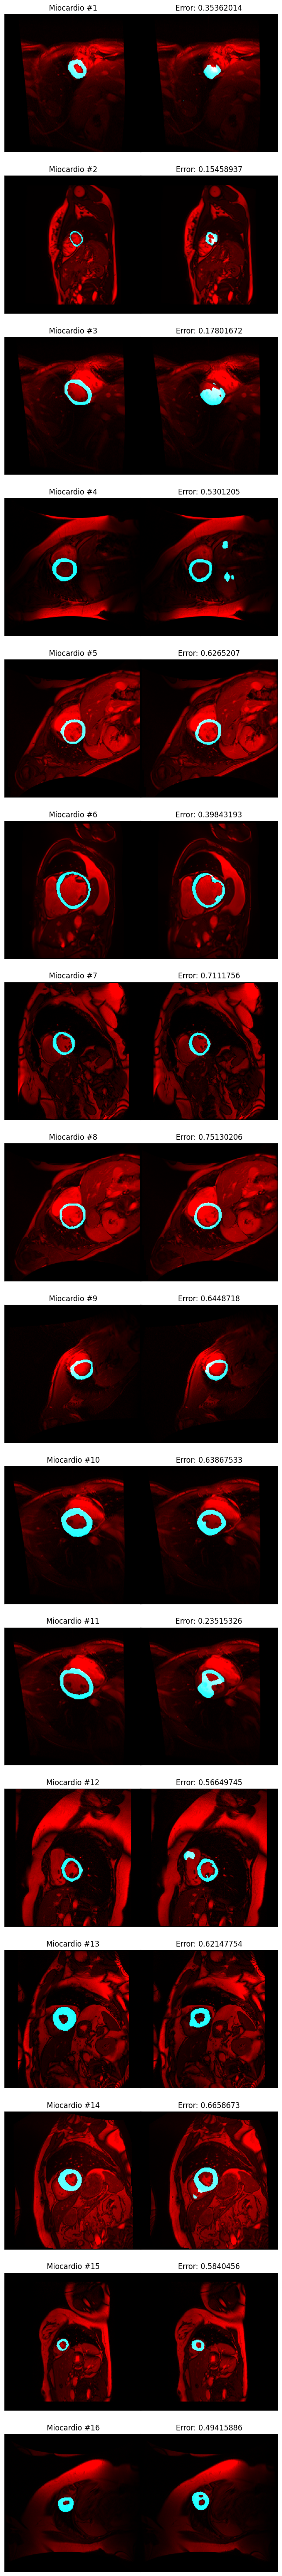

In [34]:
# Testeo de la red neuronal

r = random.randint(0, (len(test_imgs) // batch_size) - 1)
imgs, annot_real = test.__getitem__(r)
annot_modelo = model.predict(imgs)
annot_real = annot_real == 0.5
annot_modelo = 1.0 - np.round(2.0 * np.abs(annot_modelo - 0.5))
col_ar = annot_real * np.array([0, 1, 1])
col_am = annot_modelo * np.array([0, 1, 1])

# Gráfico de la identificación real vs la predicción

fig = plt.figure(figsize=(8, 4.75 * batch_size))
fig.subplots_adjust(hspace=0, wspace=-0.01)
for i in range(batch_size):
  ax = fig.add_subplot(batch_size, 2, 2 * i + 1)
  ax.set_title("Miocardio #" + str(i + 1))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow(imgs[i] + col_ar[i])
  ax = fig.add_subplot(batch_size, 2, 2 * (i + 1))
  ax.set_title("Error: " + str(error(annot_real[i], annot_modelo[i])))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow(imgs[i] + col_am[i])